In [1]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="anon", project="anon", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="anon", project="anon",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Best trials

query = {"$and": [{"tags": "submission"},
                  {"tags": {"$ne": "data-efficiency"}},
                  {"state": "finished"},
                  {"config.n_train": 800},
                  {"config.body_class": {"$ne": "ChainPendulum"}},
                  {"config.lr": {"$in": [3e-3, 1e-3]}},
                 ]}


runs, histories = zip(*get_history(query=query))

In [4]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    if network_class == "NN":
        network_class = "NeuralODE"
    body_args = tuple(run.config["body_args"])
    if len(body_args) == 0:
        body_args = ""
    elif len(body_args) == 1:
        body_args = f"{body_args[0]}-"
    else:
        body_args = f"{body_args}"
    body_class = run.config["body_class"]
    if body_class == "ChainPendulum":
        body_class = "Pendulum"
    body = f"{body_args}{body_class}"

#     rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
#     rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pred_true = (pred_zts - true_zts).pow(2).sum((2, 3, 4)).sqrt() / (pred_zts.pow(2).sum((2,3,4)).sqrt() + true_zts.pow(2).sum((2,3,4)).sqrt()) 
    rel_err_pert_true = (pert_zts - true_zts).pow(2).sum((2, 3, 4)).sqrt() / (pert_zts.pow(2).sum((2,3,4)).sqrt() + true_zts.pow(2).sum((2,3,4)).sqrt()) 


    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.cpu().numpy()
    avg_rel_err_pert = rel_err_pert_true.cpu().numpy()
    
    dt = run.config["dt"]
    integration_time = run.config["integration_time"]

    # turn into list of series from batch of series   
    series += avg_rel_err_pred.tolist()
    labels += [(body, network_class, "avg_rel_err_pred", batch, dt, integration_time) for batch in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(body, network_class, "avg_rel_err_pert", batch, dt, integration_time) for batch in range(len(avg_rel_err_pert))]

File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists


In [5]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
levels = ['Body', 'Network', "Series", "Batch", "dt", "integration_time"]
index = pd.MultiIndex.from_tuples(labels, names=levels)
df = pd.DataFrame(series, index=index).reset_index()

In [6]:
df["Body"].unique()

array(['4-CoupledPendulum', '3-CoupledPendulum', 'CoupledPendulum',
       'Rotor', 'Gyroscope', 'MagnetPendulum'], dtype=object)

In [7]:
df["Network"].unique()

array(['CLNN', 'CHNN', 'DeLaN', 'HNN', 'NeuralODE'], dtype=object)

In [8]:
df = pd.melt(df, id_vars=levels, var_name="timestep")

In [9]:
df = df.sort_values(by=levels)

In [10]:
df["time"] = df["timestep"] * df["dt"]

In [11]:
sns.set(font_scale=1.25)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000

In [12]:
df["Body"].unique()

array(['3-CoupledPendulum', '4-CoupledPendulum', 'CoupledPendulum',
       'Gyroscope', 'MagnetPendulum', 'Rotor'], dtype=object)

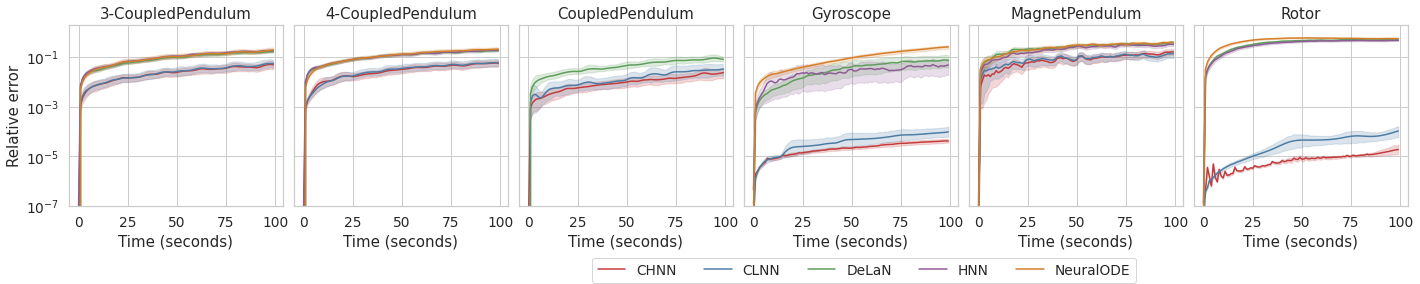

In [13]:
n_plots = len(df["Body"].unique())
fig, axes = plt.subplots(ncols=n_plots, figsize=(4 * n_plots, 4))

i = 0
for value, ax in zip(df["Body"].unique(), axes):
    data = df.loc[(df["Series"] == "avg_rel_err_pred") & (df["Body"] == value)]
    sns.lineplot(data=data, x="timestep", y="value", hue="Network", ax=ax, ci=95)
    #ax.axvline(chunk_len, label=r"$T_{minibatch}$", color="k", linestyle="--", linewidth=1.0)
    
    ax.set(yscale="log", xlabel="Time (seconds)", title=f"{value}", ylim=(1e-7, 2))
    ax.set(ylabel="")
    
    if i > 0: # hack
        ax.set(yticklabels=[])
    
    ax.legend().remove()
    i += 1

axes[0].set(ylabel="Relative error")
handles, labels = axes[-1].get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:] # Get rid of legend title
fig.subplots_adjust(bottom=0.25, wspace=0.05, hspace=0.25)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

In [14]:
fig.savefig("non-pendulum-rel-err.pdf", bbox_inches="tight")

In [15]:
df.head()

,Body,Network,Series,Batch,dt,integration_time,timestep,value,time
700,3-CoupledPendulum,CHNN,avg_rel_err_pert,0,0.05,5,0,0.000050,0
6300,3-CoupledPendulum,CHNN,avg_rel_err_pert,0,0.05,5,1,0.000062,0.05
11900,3-CoupledPendulum,CHNN,avg_rel_err_pert,0,0.05,5,2,0.000080,0.1
17500,3-CoupledPendulum,CHNN,avg_rel_err_pert,0,0.05,5,3,0.000096,0.15
23100,3-CoupledPendulum,CHNN,avg_rel_err_pert,0,0.05,5,4,0.000108,0.2


In [16]:
dts = df.pivot_table(index=["Body", "Network", "Series", "Batch"], columns="timestep", values="dt").loc[:, 0]

In [17]:
df_series = df.pivot_table(index=["Body", "Network", "Series", "Batch"], columns="timestep", values="value")
dts = df.pivot_table(index=["Body", "Network", "Series", "Batch"], columns="timestep", values="dt").loc[:, 0]
int_time = df.pivot_table(index=["Body", "Network", "Series", "Batch"], columns="timestep", values="integration_time").loc[:, 0]

y = df_series.to_numpy()
integration_wrt_timestep = np.trapz(np.log(y + 1e-8), axis=-1)
integration_wrt_t = dts * integration_wrt_timestep
geom_mean = np.exp(integration_wrt_t / int_time)

df_geom_mean = pd.DataFrame(index=df_series.index, data=geom_mean.to_numpy(), columns=["Geometric Mean"])
df_geom_mean = df_geom_mean.reset_index()

In [18]:
df_geom_mean

,Body,Network,Series,Batch,Geometric Mean
0,3-CoupledPendulum,CHNN,avg_rel_err_pert,0,0.000126
1,3-CoupledPendulum,CHNN,avg_rel_err_pert,1,0.000174
2,3-CoupledPendulum,CHNN,avg_rel_err_pert,2,0.000043
3,3-CoupledPendulum,CHNN,avg_rel_err_pert,3,0.000146
4,3-CoupledPendulum,CHNN,avg_rel_err_pert,4,0.000066
...,...,...,...,...,...
5595,Rotor,NeuralODE,avg_rel_err_pred,95,0.438358
5596,Rotor,NeuralODE,avg_rel_err_pred,96,0.398760
5597,Rotor,NeuralODE,avg_rel_err_pred,97,0.215353
5598,Rotor,NeuralODE,avg_rel_err_pred,98,0.511750


In [19]:
n_test = df["Batch"].nunique()

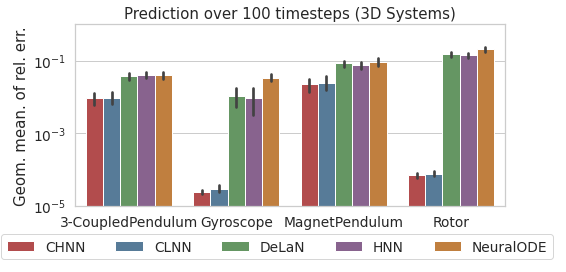

In [20]:
data = df_geom_mean[(df_geom_mean["Body"] != "CoupledPendulum")
                    & (df_geom_mean["Body"] != "4-CoupledPendulum")]
data = data.sort_values(by=["Network", "Body"])

fig, ax = plt.subplots(figsize=(7.7,4))
sns.barplot(data=data, x="Body", y="Geometric Mean",
             ci=95, hue="Network", ax=ax)
ax.set(yscale="log", ylabel="Geom. mean. of rel. err.", xlabel=None,
       title=f"Prediction over 100 timesteps (3D Systems)",
       ylim=(1e-5, 1))
ax.legend().remove()

xlabels = [f"{system}" for system in data["Body"].unique()]
ax.set_xticklabels(xlabels, rotation=0)

handles, labels = ax.get_legend_handles_labels()
fig.subplots_adjust(bottom=0.25)
#fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)
fig.legend(handles=handles, labels=labels, bbox_to_anchor=(0., 0.04, 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1, mode="expand")

In [21]:
fig.savefig("non-pendulum-geom-mean.pdf", bbox_inches="tight")

In [22]:
data.to_csv("non-pendulum-geom-mean.csv", index=False)